<a href="https://colab.research.google.com/github/HRJ369/CL249--Computational-Lab/blob/main/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

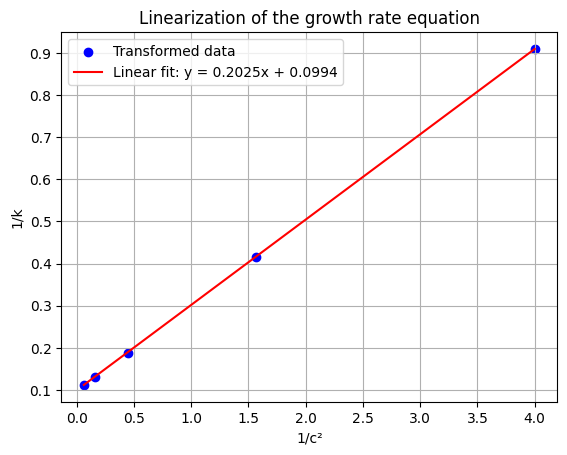

Estimated k_max: 10.0607
Estimated c_s: 2.0372
Predicted growth rate at c = 2 mg/L: 6.6658 per d


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Given data
c = np.array([0.5, 0.8, 1.5, 2.5, 4.0])
k = np.array([1.1, 2.4, 5.3, 7.6, 8.9])

# Transform the data
x = 1 / c**2
y = 1 / k

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate k_max and c_s from slope and intercept
k_max = 1 / intercept
c_s = slope * k_max

# Predict the growth rate at c = 2 mg/L
c_predict = 2
k_predict = k_max * c_predict**2 / (c_s + c_predict**2)

# Plotting the linear regression
plt.scatter(x, y, label='Transformed data', color='blue')
plt.plot(x, slope * x + intercept, label=f'Linear fit: y = {slope:.4f}x + {intercept:.4f}', color='red')
plt.xlabel('1/c²')
plt.ylabel('1/k')
plt.title('Linearization of the growth rate equation')
plt.legend()
plt.grid()
plt.show()

# Output results
print(f"Estimated k_max: {k_max:.4f}")
print(f"Estimated c_s: {c_s:.4f}")
print(f"Predicted growth rate at c = 2 mg/L: {k_predict:.4f} per d")


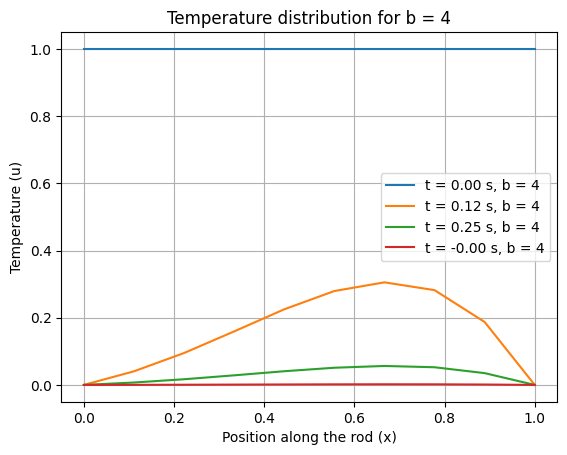

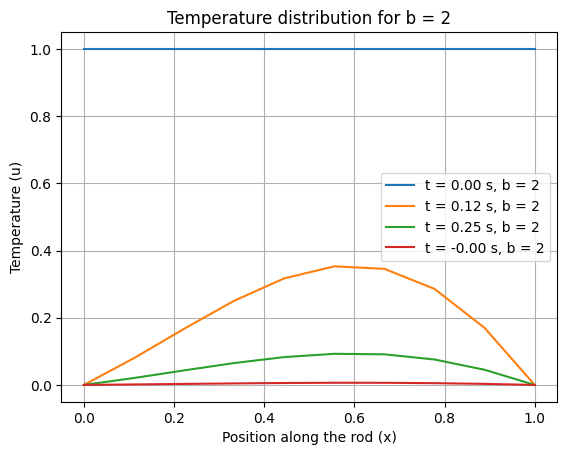

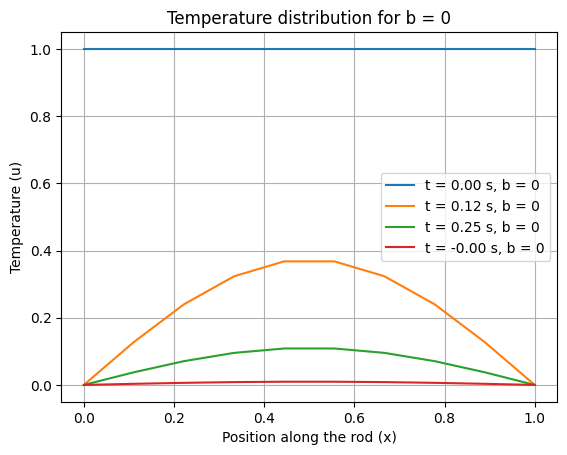

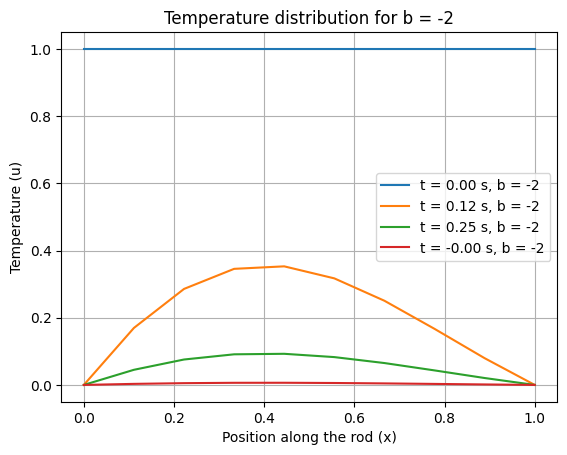

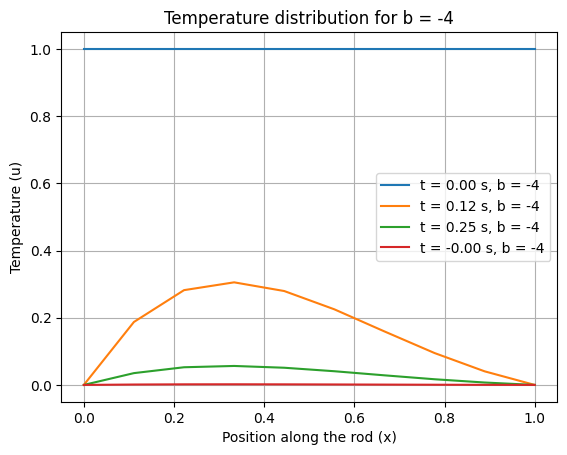

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Length of the rod (non-dimensionalized)
Nx = 10  # Number of spatial grid points
dx = L / (Nx - 1)  # Spatial step size
dt = 0.001  # Time step size
T_total = 0.5  # Total simulation time
Nt = int(T_total / dt)  # Number of time steps

# Boundary and initial conditions
u_left = 0  # u(0, t) = 0 (boundary condition at left)
u_right = 0  # u(1, t) = 0 (boundary condition at right)
u_initial = np.ones(Nx)  # u(x, 0) = 1 (initial condition across the rod)

# Values of b to solve for
b_values = [4, 2, 0, -2, -4]

# Crank-Nicolson matrix setup
alpha = 1.0  # Diffusivity parameter
r = alpha * dt / dx**2  # Stability parameter

# Ensure r is within a stable range
if r >= 1:
    print(f"Warning: r = {r} might still be too large. Consider reducing dt or increasing dx for stability.")

# Initialize arrays
x = np.linspace(0, L, Nx)
u = np.zeros((Nx, Nt))  # Solution matrix u(x, t)
u[:, 0] = u_initial  # Apply initial condition u(x, 0) = 1

# Boundary conditions
u[0, :] = u_left  # u(0, t) = 0 (left boundary)
u[-1, :] = u_right  # u(1, t) = 0 (right boundary)

# Time-stepping loop for different values of b
for b in b_values:
    # Reset initial condition for each b value
    u[:, 0] = u_initial

    # Crank-Nicolson matrix setup
    A = np.zeros((Nx - 2, Nx - 2))  # Tridiagonal matrix for Crank-Nicolson
    for i in range(Nx - 2):
        A[i, i] = 1 + r  # Diagonal elements
        if i > 0:
            A[i, i - 1] = -r / 2  # Lower diagonal
        if i < Nx - 3:
            A[i, i + 1] = -r / 2  # Upper diagonal

    # Time loop
    for n in range(0, Nt - 1):
        B = np.zeros(Nx - 2)
        for i in range(1, Nx - 1):
            B[i - 1] = (r / 2) * u[i - 1, n] + (1 - r) * u[i, n] + (r / 2) * u[i + 1, n] - b * dt * (u[i + 1, n] - u[i - 1, n]) / (2 * dx)

        # Apply boundary conditions in the right-hand side vector
        B[0] += (r / 2) * u_left
        B[-1] += (r / 2) * u_right

        # Solve the system of equations
        u[1:-1, n + 1] = np.linalg.solve(A, B)

    # Plot the results for this value of b
    for t_index in [0, Nt // 4, Nt // 2, -1]:
        plt.plot(x, u[:, t_index], label=f't = {t_index * dt:.2f} s, b = {b}')

    plt.xlabel('Position along the rod (x)')
    plt.ylabel('Temperature (u)')
    plt.title(f'Temperature distribution for b = {b}')
    plt.legend()
    plt.grid(True)
    plt.show()


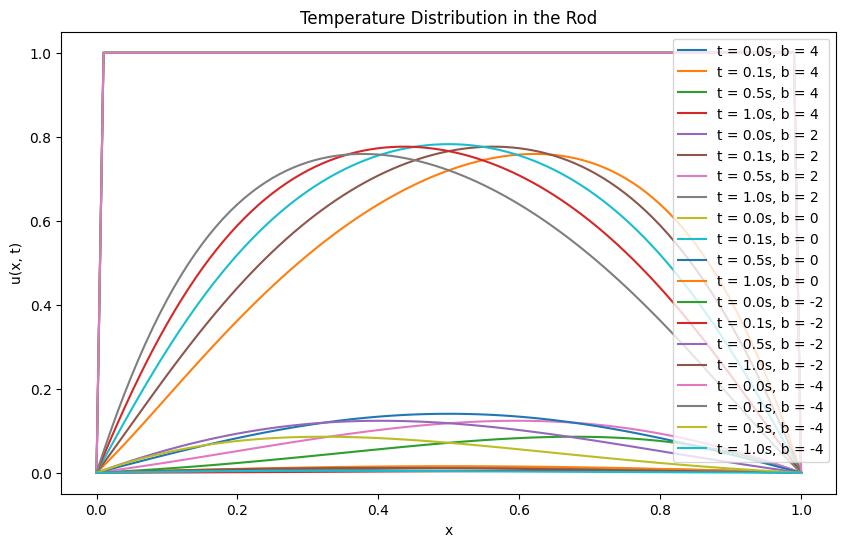

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0          # Length of the rod
Nx = 100         # Number of spatial points (good accuracy)
Ax = L / Nx      # Spatial step size
At = 0.05     # Time step size for good accuracy

x = np.linspace(0, L, Nx+1)
dx = x[1] - x[0]

# Crank-Nicolson coefficients with second-order finite difference
def CN_coeffs(b, Nx, dx, dt):
    alpha = dt / dx**2
    beta = b * dt / (2 * dx)
    A = np.zeros((Nx-1, Nx-1))
    for i in range(Nx-1):
        if i > 0:
            A[i, i-1] = -alpha / 2 - beta / 2
        A[i, i] = 1 + alpha
        if i < Nx-2:
            A[i, i+1] = -alpha / 2 + beta / 2
    return A

# Initialize u(x,t) with boundary and initial conditions
def initialize_u(Nx):
    u = np.ones(Nx+1)
    u[0] = u[-1] = 0 # u(x,0) = 1 for 0 < x <  1
    return u

# Time stepping with Crank-Nicolson and second-order finite difference analogue
def crank_nicolson(b, Nx, Nt, dx, dt):
    u = initialize_u(Nx)  # Initial condition u(x,0) = 1
    A = CN_coeffs(b, Nx, dx, dt)
    for n in range(1, Nt+1):
        # Apply boundary conditions at each time step
        u_new = np.linalg.solve(A, u[1:Nx])  # Solving for the interior points only
        u[1:Nx] = u_new
        u[0] = 0   # Boundary condition u(0,t) = 0
        u[Nx] = 0  # Boundary condition u(1,t) = 0
    return u

# Plotting
def plot_solution(u, x, t, b):
    plt.plot(x, u, label=f't = {t}s, b = {b}')

# Solve and plot for different b values
b_values = [4, 2, 0, -2, -4]
time_points = [0.0, 0.1, 0.5, 1.0]

plt.figure(figsize=(10, 6))
for b in b_values:
    for t in time_points:
        Nt = int(t / At)  # Number of time steps to reach time 't'
        u = crank_nicolson(b, Nx, Nt, dx, At)
        plot_solution(u, x, t, b)

plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Temperature Distribution in the Rod')
plt.legend()
plt.show()